# Imports

In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns  # Opcional, para estilização
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LinearRegression

# Obtenção dos dados

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Algoritmo

In [25]:
def choose_optimal_lv(validation, calibration, pls_model, max_lv, X_scaled, Y_scaled):
    lvs = []
    k = 1
    
    for j in range(1, max_lv):
        if j + 1 <= max_lv:
            rpearson_cal_j = calibration.loc[j + 1, 'rpearson_cal']
            rpearson_cv_j = validation.loc[j + 1, 'rpearson_cv']
            rpearson_cal_j_plus_1 = calibration.loc[j, 'rpearson_cal']
            rpearson_cv_j_plus_1 = validation.loc[j, 'rpearson_cv']
            
            # Verifica se há uma melhora em ambas as métricas rpearson (calibração e validação cruzada)
            aux_cal = rpearson_cal_j / rpearson_cal_j_plus_1
            aux_cv = rpearson_cv_j / rpearson_cv_j_plus_1
            
            # Critério: Aumenta o LV se houver uma melhora significativa em ambas as métricas
            if aux_cal > 1 and aux_cv > 1 and ((aux_cv - 1) * 100 >= 2):
                lvs.append(j + 1)
                k += 1

    # Se nenhum LV for selecionado, use o primeiro por padrão
    if len(lvs) == 0:
        return 1

    lv_num = lvs[-1]  # Inicialmente, assume-se o maior LV selecionado

    if len(lvs) > 1:
        pls_model = PLSRegression(n_components=lvs[-2])
        pls_model.fit(X_scaled, Y_scaled)

        # Avalia a estabilidade dos coeficientes do modelo
        for w in range(k - 2):
            if pls_model.coef_.shape[1] > 3:
                if lvs[w + 1] < pls_model.coef_.shape[0] and pls_model.coef_[lvs[w + 1], 3] < 1:
                    lv_num = lvs[w]
                    break

    return lv_num

def train_model(X_scaled, Y_scaled):
    max_lv = 10
    loo = LeaveOneOut()

    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pls_model = PLSRegression(n_components=lv, max_iter=500)

        # Calibração do modelo
        pls_model.fit(X_scaled, Y_scaled)
        predictions_train = pls_model.predict(X_scaled)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        if Y_scaled.ndim == 1:
            Y_scaled = Y_scaled.reshape(-1, 1)
        if predictions_train.ndim == 1:
            predictions_train = predictions_train.reshape(-1, 1)

        correlation_cal = np.corrcoef(Y_scaled[:, 0], predictions_train[:, 0])[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train.flatten()

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(pls_model, X_scaled, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        if predictions_cv.ndim == 1:
            predictions_cv = predictions_cv.reshape(-1, 1)

        correlation_cv = np.corrcoef(Y_scaled[:, 0], predictions_cv[:, 0])[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv.flatten()
    
    # Escolha o LV ótimo
    optimal_lv = choose_optimal_lv(validation, calibration, pls_model, max_lv, X_scaled, Y_scaled)
    
    # Treina o modelo final com o LV ótimo
    model = PLSRegression(n_components=optimal_lv)
    model.fit(X_scaled, Y_scaled)
    
    return calibration, validation, optimal_lv, model, Y_values


def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, X_pred, y_pred, lv_number):
    X_centered, _, _, _ = center_data(X_pred.iloc[:,6:].values, y_pred.values)
    pred = model.predict(X_pred.iloc[:,6:].values)
       
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation'])
    
    prediction = pd.DataFrame(columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'bias_cv', 'secv_cv'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[0:,0].tolist()
        
    return prediction, Y_predict

def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, attribute, filter):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    metrics_dict = pd.DataFrame({
    'Y': ['Referência', 'Predição'],
    'R²': [r2_opt, r2_pred],
    'RMSE': [rmse_opt, rmse_pred],
    'Offset': [offset_opt, offset_pred],
    'Slope': [slope_opt,slope_pred]
    })
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()
    
    return metrics_dict

def pred_plot(Y_predict, plot=True):
    X = Y_predict['Y_pred'].values.reshape(-1, 1)
    y = Y_predict['Y_true'].values

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    offset = model.intercept_

    # Criar pontos para a linha de regressão
    X_line = np.array([[Y_predict['Y_pred'].min()], [Y_predict['Y_pred'].max()]])
    y_pred_line = model.predict(X_line)

    r2 = r2_score(y, Y_predict['Y_pred'])
    rmse = np.sqrt(mean_squared_error(y, Y_predict['Y_pred']))
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(Y_predict['Y_pred'], y, color='green', label='Dados')
        plt.plot(X_line, y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')

        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.95, 0.05, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
            transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right')
        plt.tight_layout()
        plt.show()
    
    metrics_dict = pd.DataFrame({
    'Y': ['Validação'],
    'R²': [r2],
    'RMSE': [rmse],
    'Offset': [offset],
    'Slope': [slope]
    })
    
    return metrics_dict

def build_model(X_cal, Y_cal, X_val, Y_val, attribute, filter):
       
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    #abs_scaled, qua_scaled, m_abs, m_qua = center_data(X.iloc[:,6:].values, Y.values)
    calibration, validation, lv_num, model, Y_values = train_model(X.iloc[:,6:].values, Y.values)
    print(f'Número de componentes: {lv_num}')
        
    prediction, Y_predict = predict(model, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_infos = plot_pred_vs_ref(Y_true, Y_pred, Y_opt, attribute, filter)
    chart_data = pd.DataFrame({
    'Sample': Y_values.index,  # Identificador da amostra, pode ser index ou outra coluna específica
    'Y_true': Y_true,
    'Y_opt': Y_opt,
    'Y_pred': Y_pred
    })  
    # Exibe o gráfico uma vez
    pred_plot(Y_predict)

    plot_infos_p = pred_plot(Y_predict, plot=False)

    plot_infos_df = plot_infos.copy()
    plot_infos_pre = pd.concat([plot_infos_df, plot_infos_p], ignore_index=True)
    
    return calibration, validation, Y_predict, plot_infos_pre



# Função de saída dos dados


In [27]:
plot_infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre


# MSC - PLSR

Número de componentes: 8


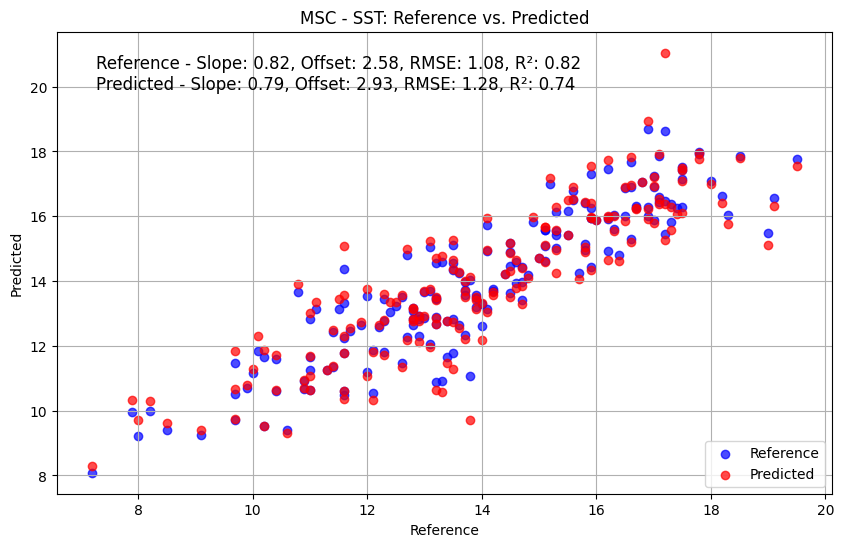

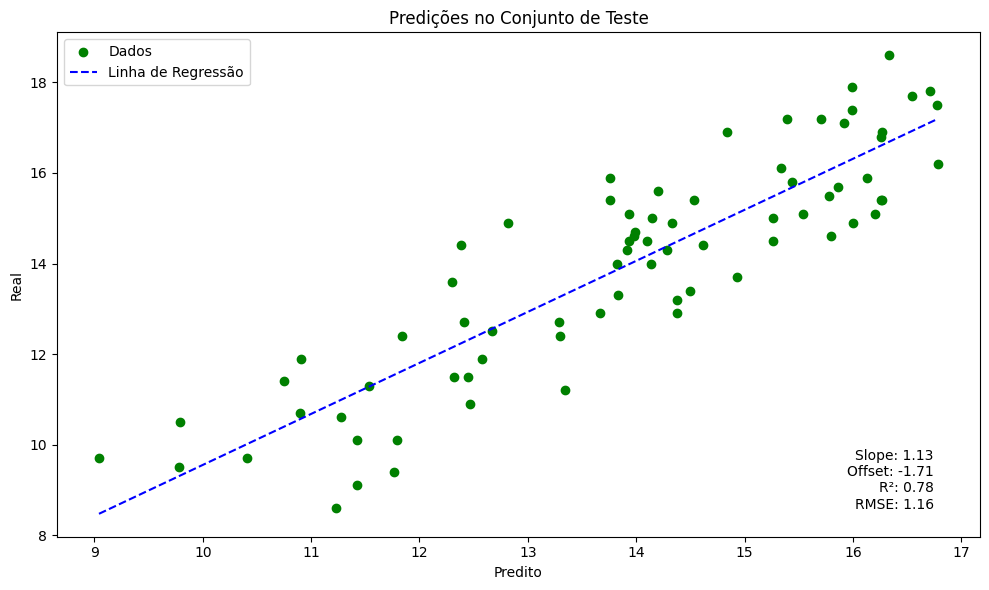

In [28]:
calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst, plot_infos = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'], 'SST', 'MSC')

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'SST')

Número de componentes: 9


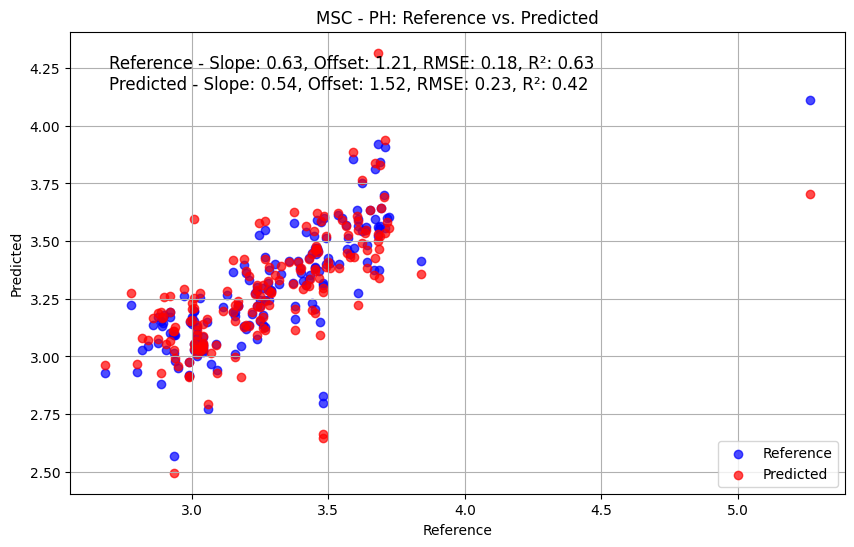

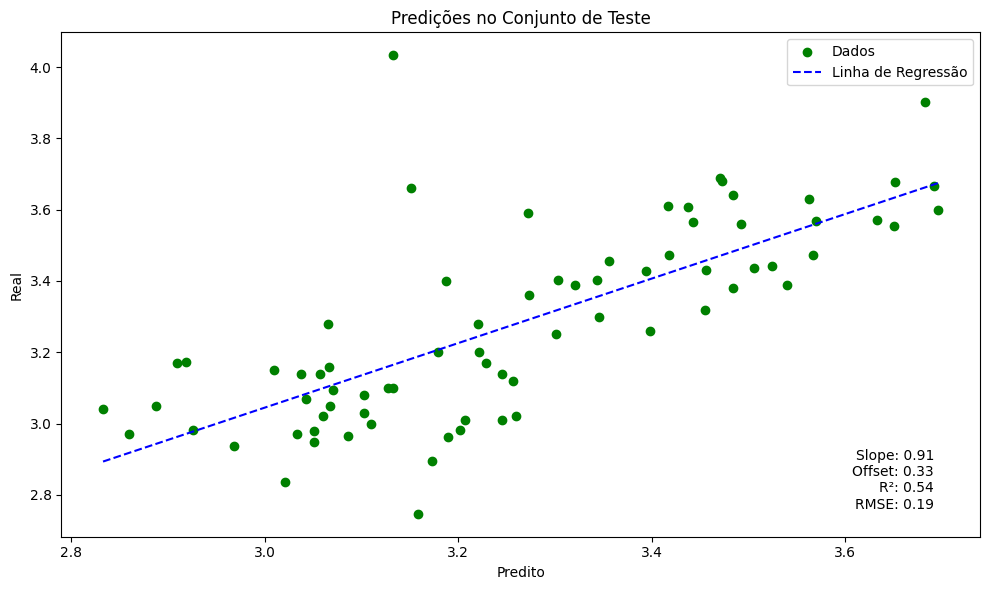

In [29]:
calibration_msc_ph, validation_msc_ph, Y_predict_msc_ph, plot_infos = build_model(df_msc_cal, df_msc_cal['PH'], df_msc_val, df_msc_val['PH'], 'PH', 'MSC')

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'PH')

Número de componentes: 9


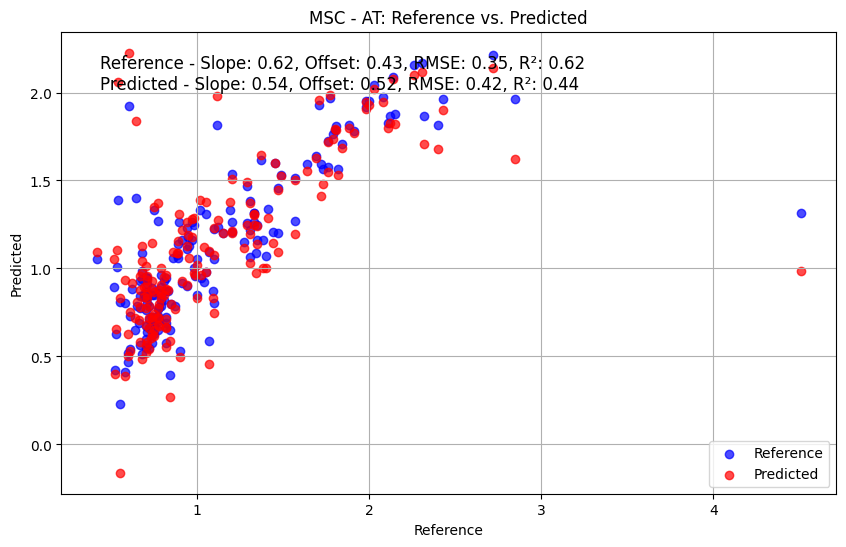

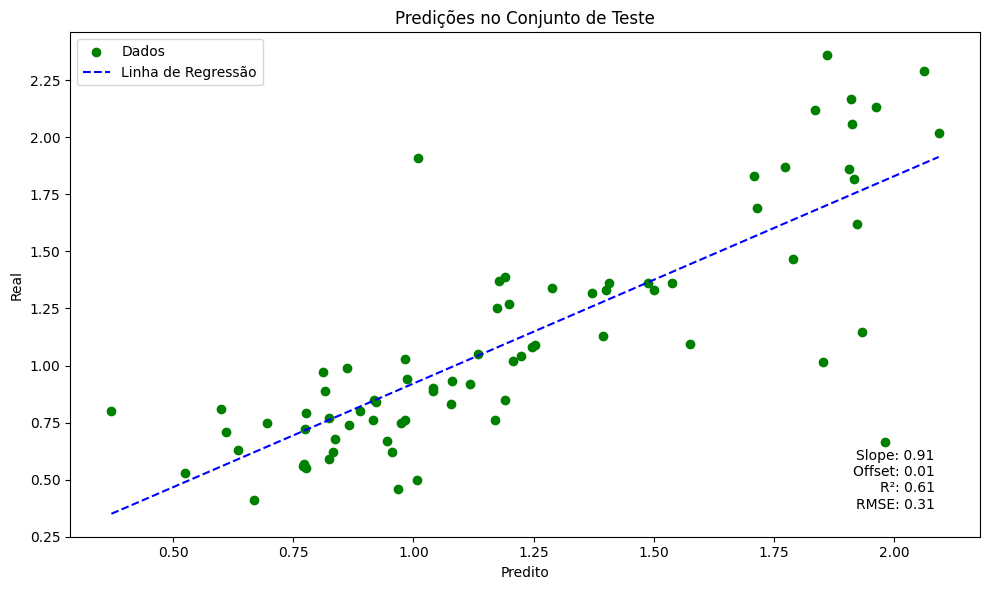

In [30]:
calibration_msc_at, validation_msc_at, Y_predict_msc_at, plot_infos = build_model(df_msc_cal, df_msc_cal['AT'], df_msc_val, df_msc_val['AT'], 'AT', 'MSC')

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'AT')


Número de componentes: 6


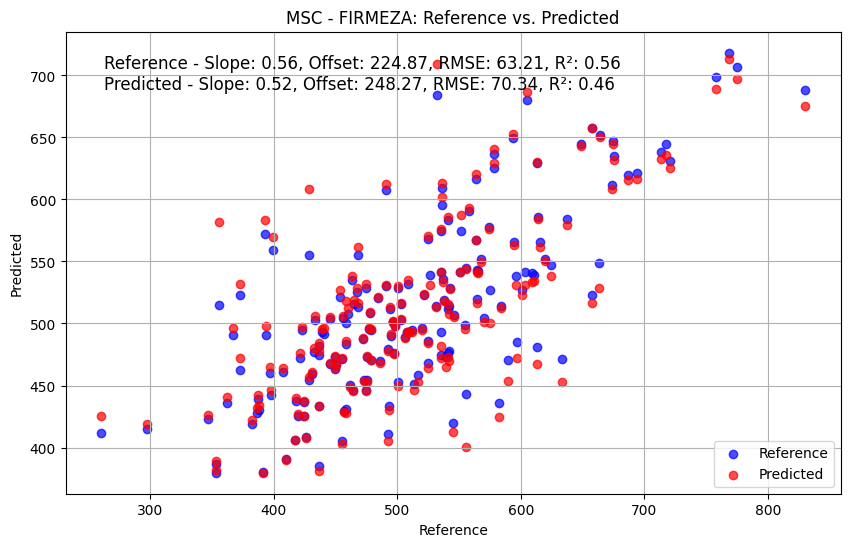

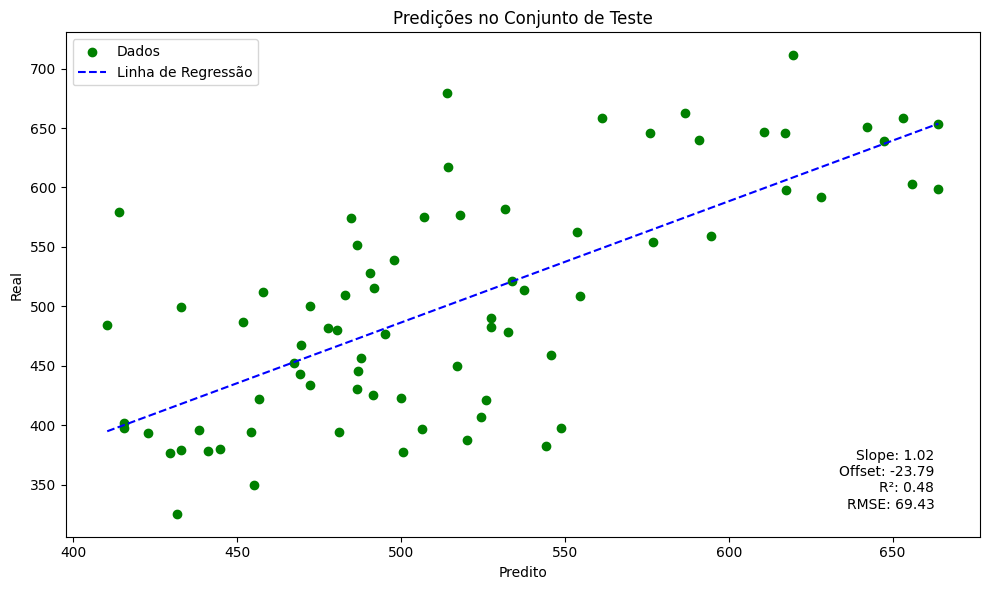

In [31]:
calibration_msc_f, validation_msc_f, Y_predict_msc_f, plot_infos = build_model(df_msc_cal, df_msc_cal['FIRMEZA (N)'], df_msc_val, df_msc_val['FIRMEZA (N)'], 'FIRMEZA', 'MSC')

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'FIRMEZA (N)')


Número de componentes: 6


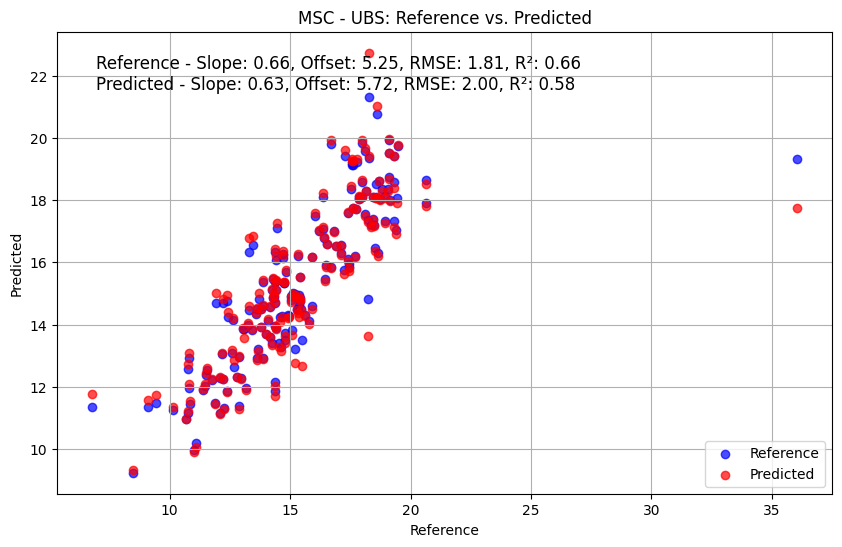

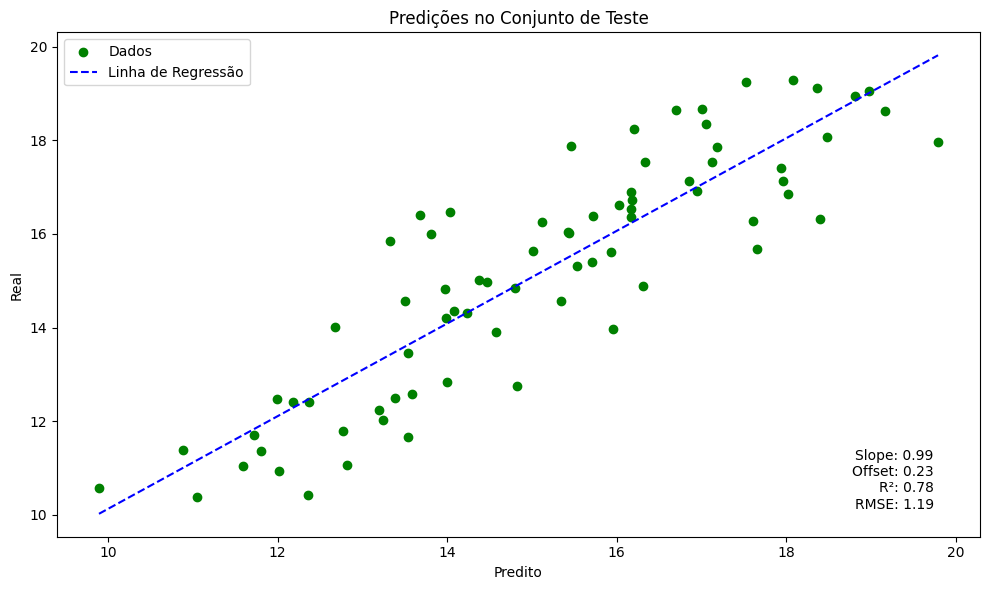

In [32]:
calibration_msc_f, validation_msc_f, Y_predict_msc_f, plot_infos = build_model(df_msc_cal, df_msc_cal['UBS (%)'], df_msc_val, df_msc_val['UBS (%)'], 'UBS', 'MSC')

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'UBS (%)')

In [33]:
plot_infos_msc.to_excel('plot_infos_plsr_msc.xlsx', index=False)
plot_infos_msc

,Attribute,Y,R²,RMSE,Offset,Slope
0,SST,Referência,0.815555,1.083463,2.584343,0.815555
1,SST,Predição,0.742803,1.279419,2.928089,0.791602
2,SST,Validação,0.777025,1.160451,-1.714047,1.126645
3,PH,Referência,0.633388,0.184875,1.206001,0.633388
4,PH,Predição,0.420776,0.232379,1.523936,0.537266
5,PH,Validação,0.536121,0.185068,0.329715,0.905008
6,AT,Referência,0.617119,0.351064,0.427658,0.617119
7,AT,Predição,0.441849,0.423868,0.520755,0.536407
8,AT,Validação,0.607637,0.308806,0.012329,0.908653
9,FIRMEZA (N),Referência,0.561641,63.206217,224.873206,0.561641


# SNV - PLSR

Número de componentes: 7


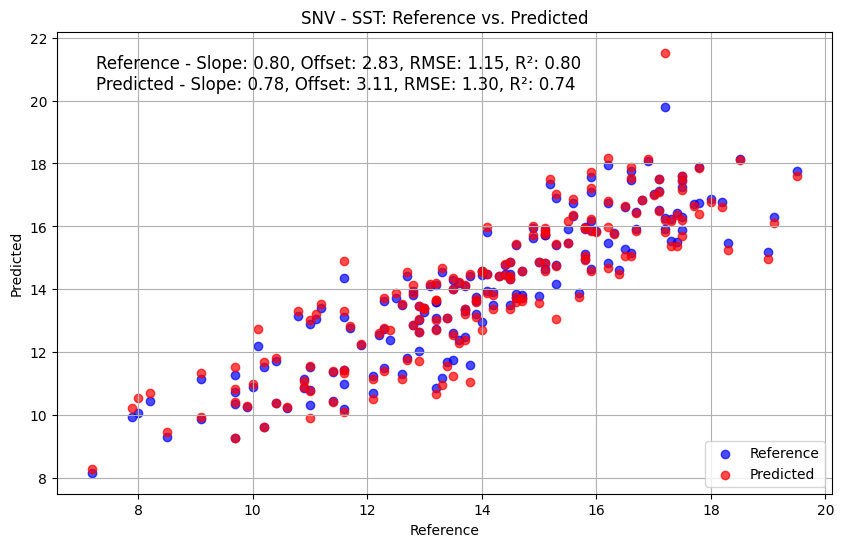

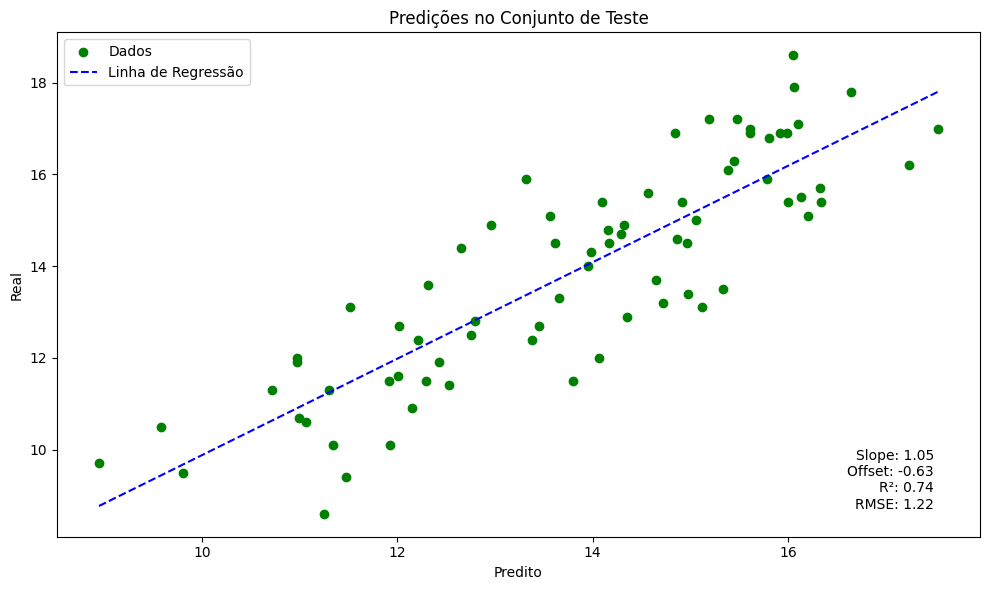

In [34]:
calibration_snv_sst, validation_snv_sst, Y_predict_snv_sst, plot_infos = build_model(df_snv_cal, df_snv_cal['SST'], df_snv_val, df_snv_val['SST'], 'SST', 'SNV')

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'SST')

Número de componentes: 8


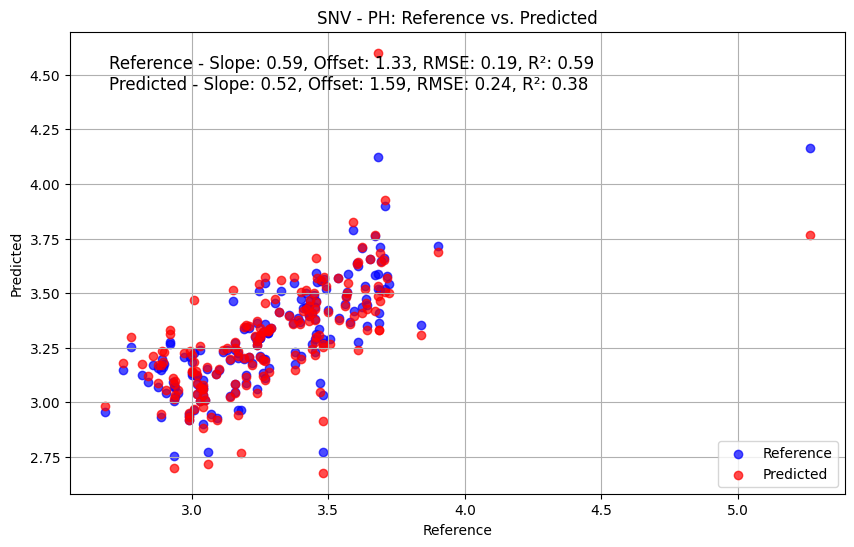

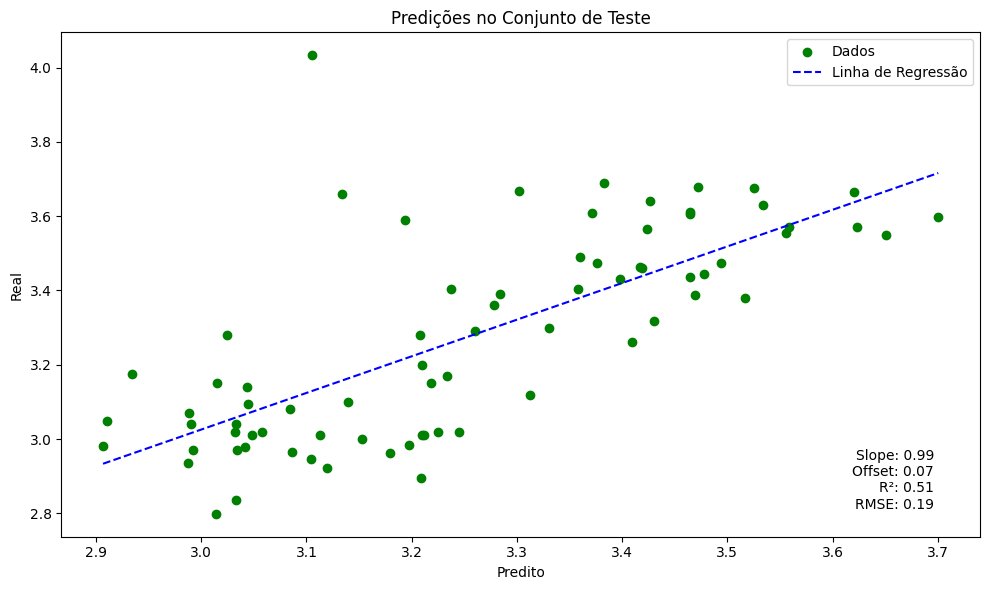

In [35]:
calibration_snv_ph, validation_snv_ph, Y_predict_snv_ph, plot_infos = build_model(df_snv_cal, df_snv_cal['PH'], df_snv_val, df_snv_val['PH'], 'PH', 'SNV')

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'PH')

Número de componentes: 7


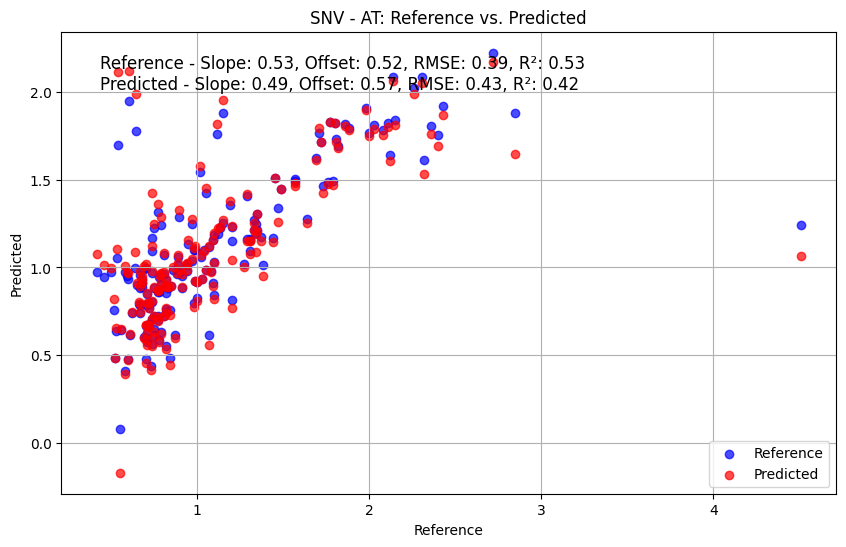

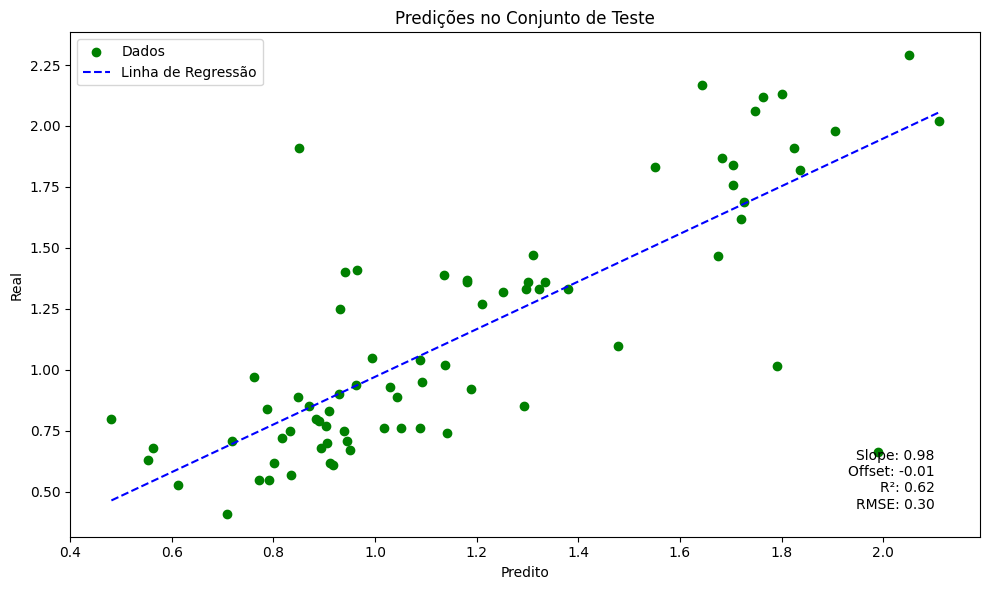

In [36]:
calibration_snv_at, validation_snv_at, Y_predict_snv_at, plot_infos = build_model(df_snv_cal, df_snv_cal['AT'], df_snv_val, df_snv_val['AT'], 'AT', 'SNV')

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'AT')

Número de componentes: 5


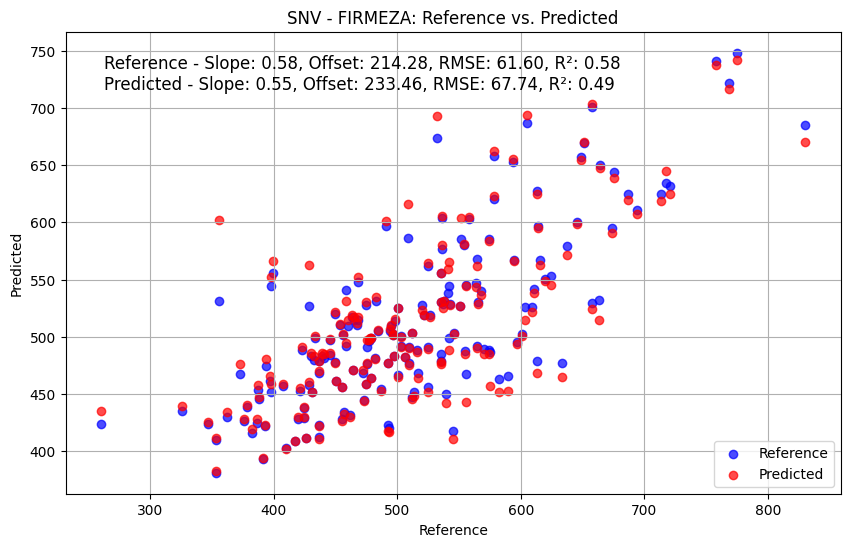

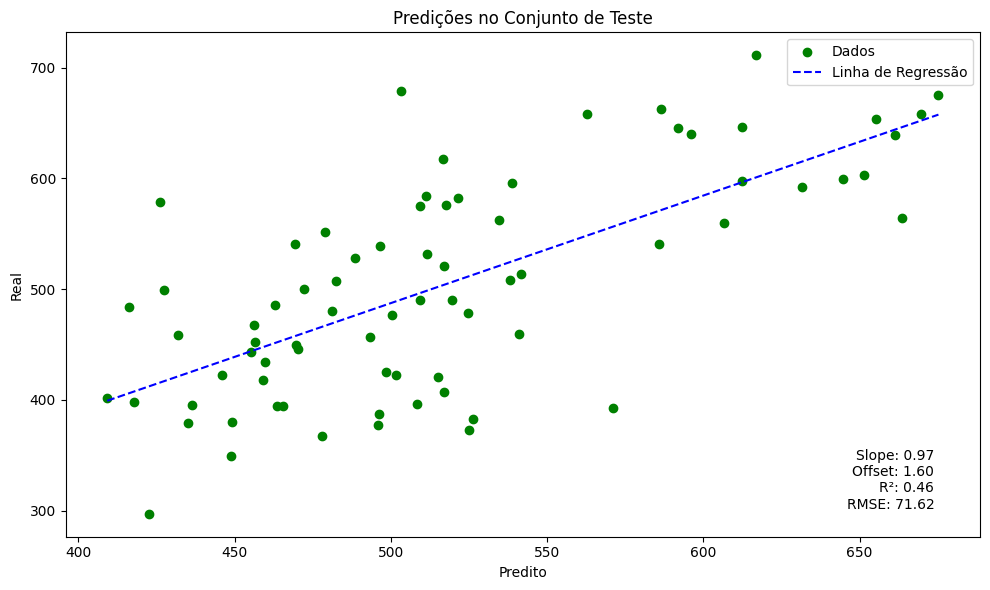

In [37]:
calibration_snv_f, validation_snv_f, Y_predict_snv_f, plot_infos = build_model(df_snv_cal, df_snv_cal['FIRMEZA (N)'], df_snv_val, df_snv_val['FIRMEZA (N)'], 'FIRMEZA', 'SNV')

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'FIRMEZA (N)')

Número de componentes: 6


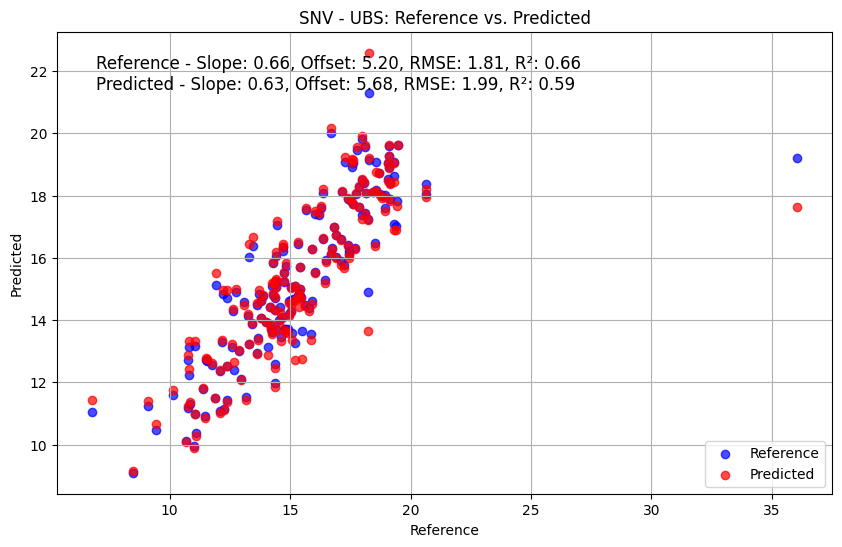

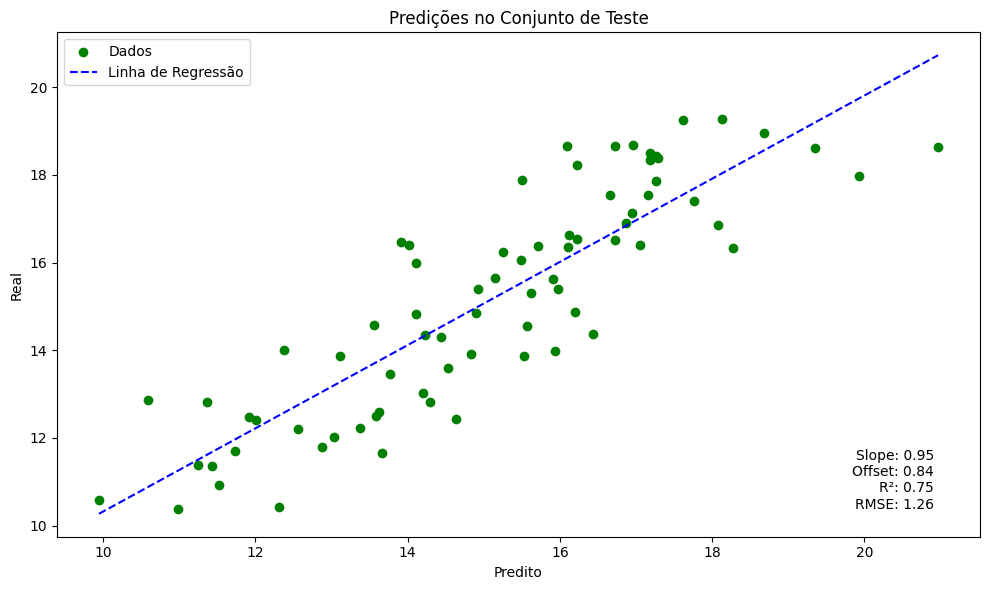

In [38]:
calibration_snv_ubs, validation_snv_ubs, Y_predict_snv_ubs, plot_infos = build_model(df_snv_cal, df_snv_cal['UBS (%)'], df_snv_val, df_snv_val['UBS (%)'], 'UBS', 'SNV')

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'UBS (%)')

In [39]:
plot_infos_snv.to_excel('plot_infos_plsr_snv.xlsx', index=False)
plot_infos_snv

,Attribute,Y,R²,RMSE,Offset,Slope
0,SST,Referência,0.797987,1.146235,2.834875,0.797987
1,SST,Predição,0.739928,1.300562,3.114057,0.778552
2,SST,Validação,0.737413,1.223758,-0.632382,1.051254
3,PH,Referência,0.594809,0.193587,1.333452,0.594809
4,PH,Predição,0.381046,0.239263,1.589288,0.516903
5,PH,Validação,0.514361,0.191459,0.068686,0.985665
6,AT,Referência,0.532153,0.387563,0.516273,0.532153
7,AT,Predição,0.415384,0.433237,0.568539,0.485037
8,AT,Validação,0.621627,0.303798,-0.005369,0.976943
9,FIRMEZA (N),Referência,0.581797,61.603579,214.276253,0.581797


# SG - PLSR

Número de componentes: 7


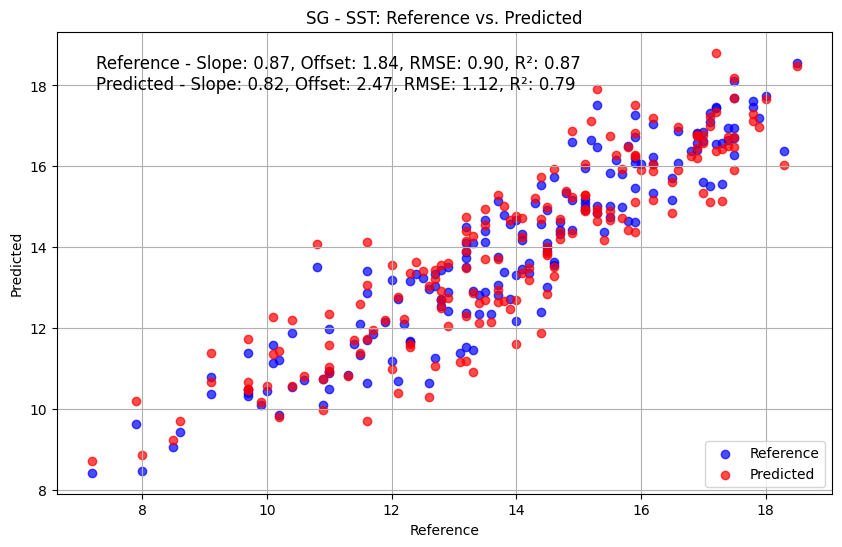

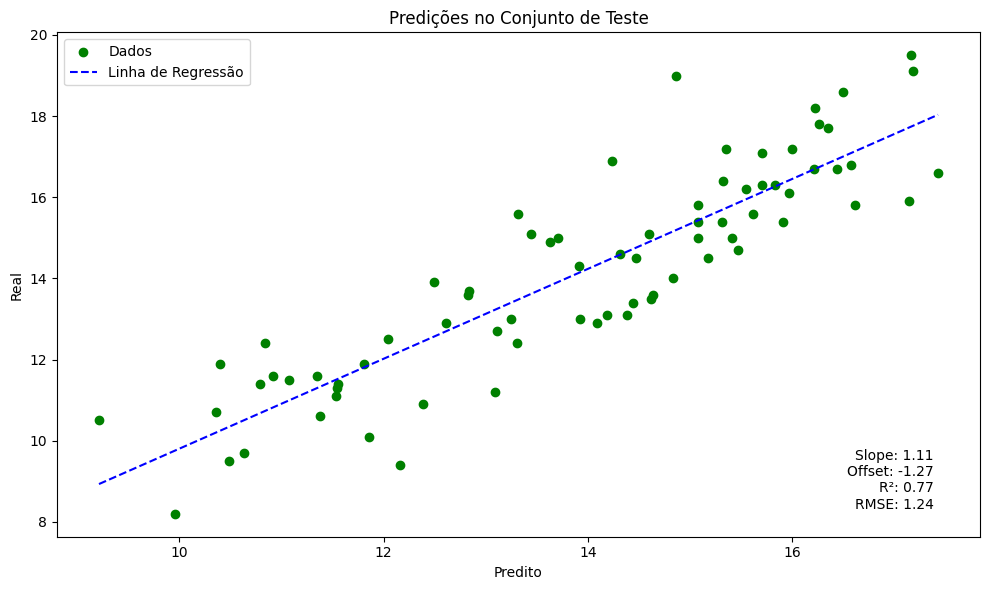

In [40]:
calibration_sg_sst, validation_sg_sst, Y_predict_sg_sst, plot_infos = build_model(df_sg_cal, df_sg_cal['SST'], df_sg_val, df_sg_val['SST'], 'SST', 'SG')

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'SST')

Número de componentes: 9


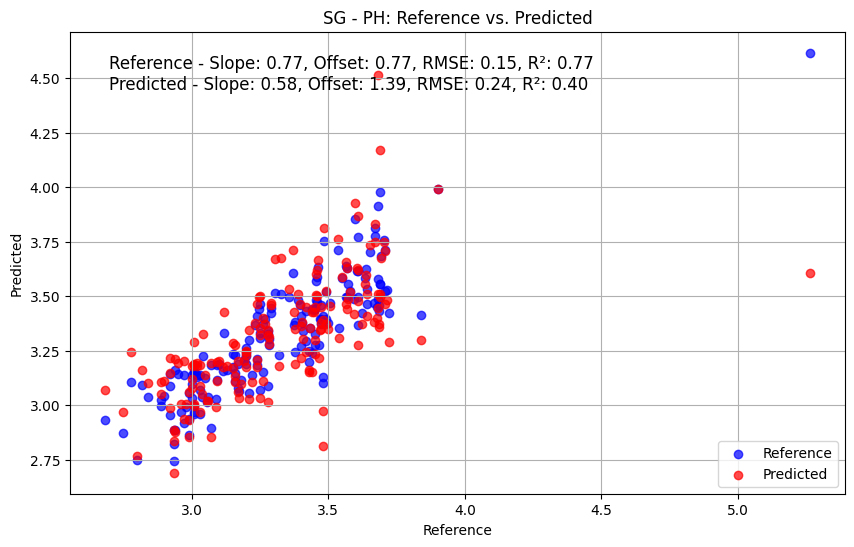

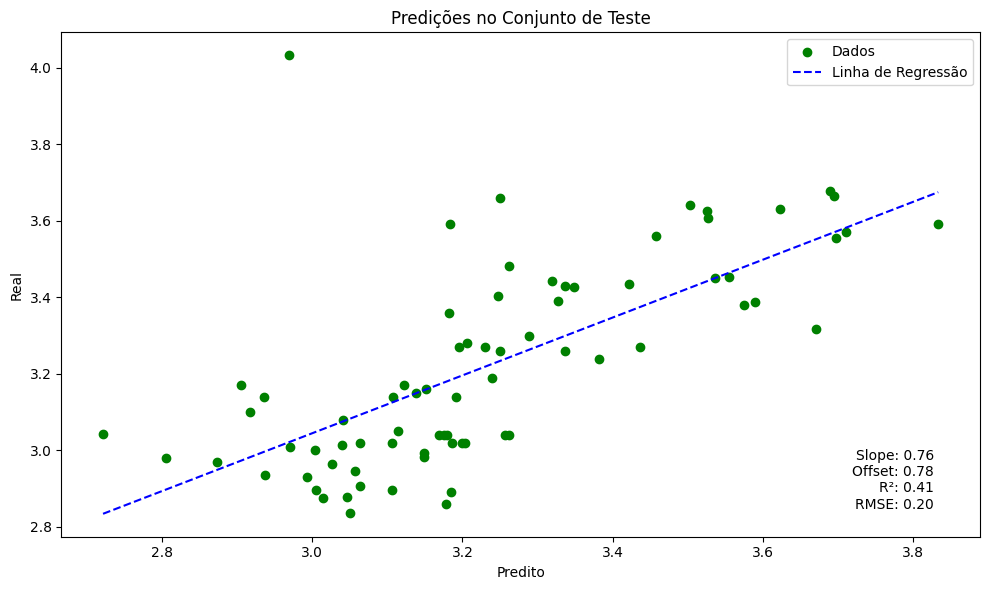

In [41]:
calibration_sg_ph, validation_sg_ph, Y_predict_sg_ph, plot_infos = build_model(df_sg_cal, df_sg_cal['PH'], df_sg_val, df_sg_val['PH'], 'PH', 'SG')

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'PH')

Número de componentes: 5


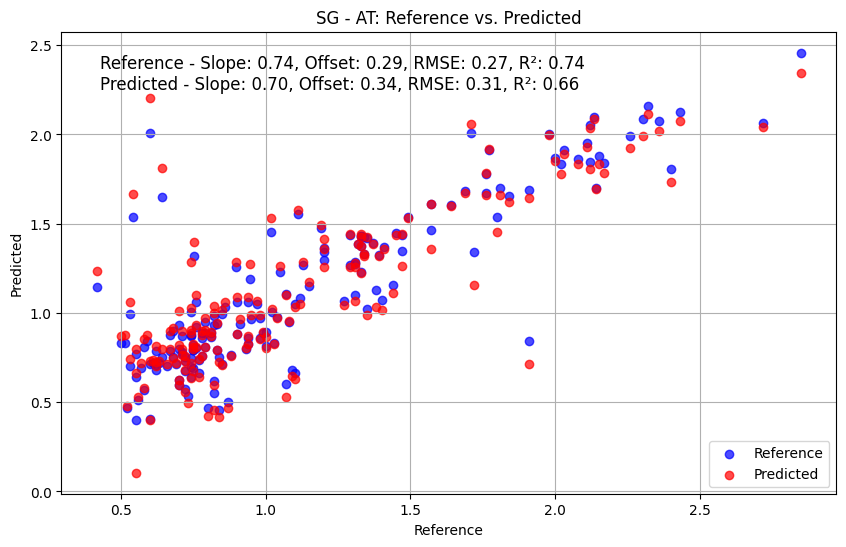

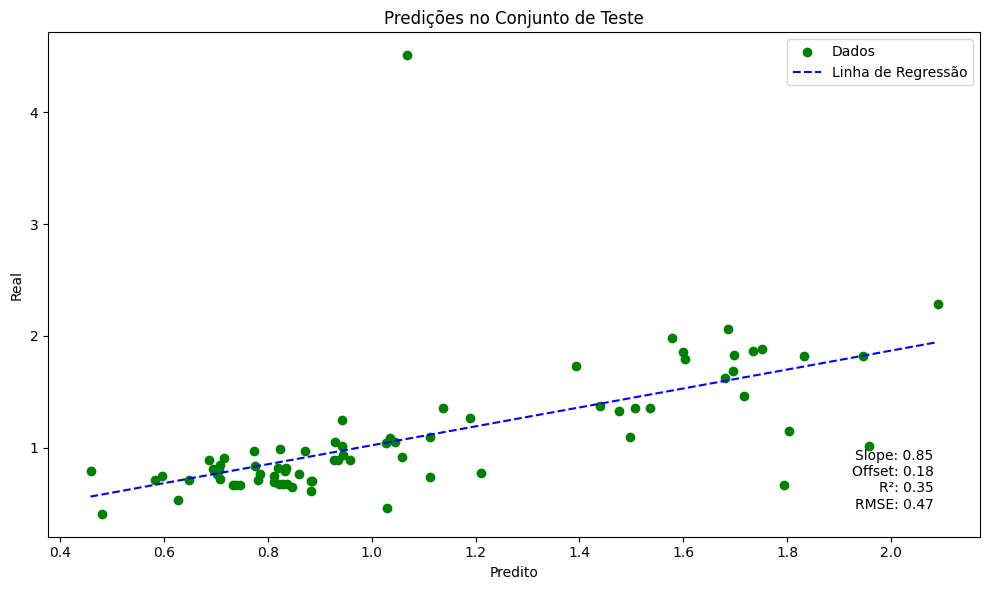

In [42]:
calibration_sg_at, validation_sg_at, Y_predict_sg_at, plot_infos = build_model(df_sg_cal, df_sg_cal['AT'], df_sg_val, df_sg_val['AT'], 'AT', 'SG')

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'AT')

Número de componentes: 6


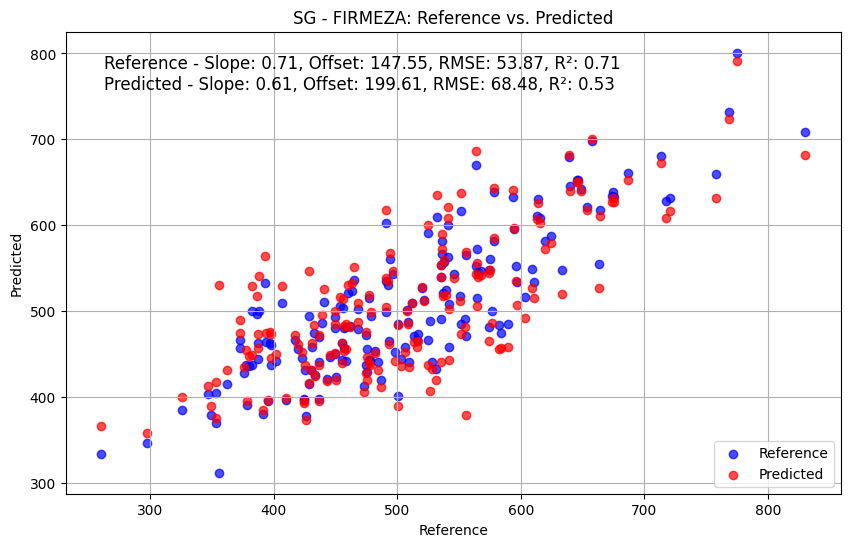

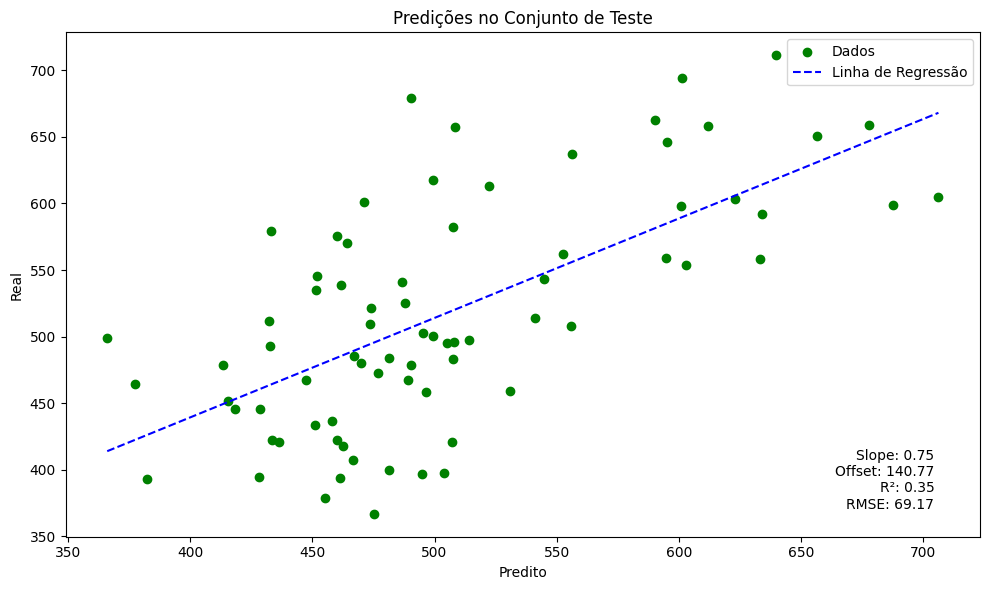

In [43]:
calibration_sg_f, validation_sg_f, Y_predict_sg_f, plot_infos = build_model(df_sg_cal, df_sg_cal['FIRMEZA (N)'], df_sg_val, df_sg_val['FIRMEZA (N)'], 'FIRMEZA', 'SG')

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'FIRMEZA (N)')

Número de componentes: 6


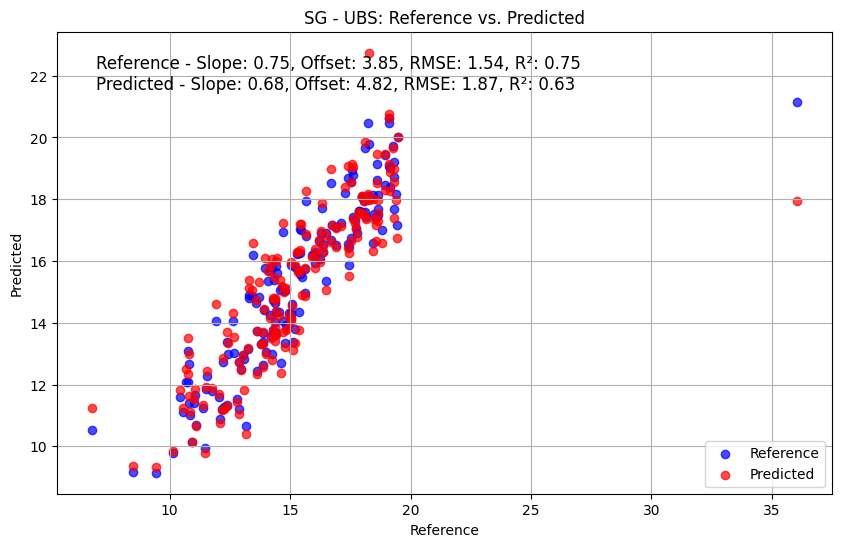

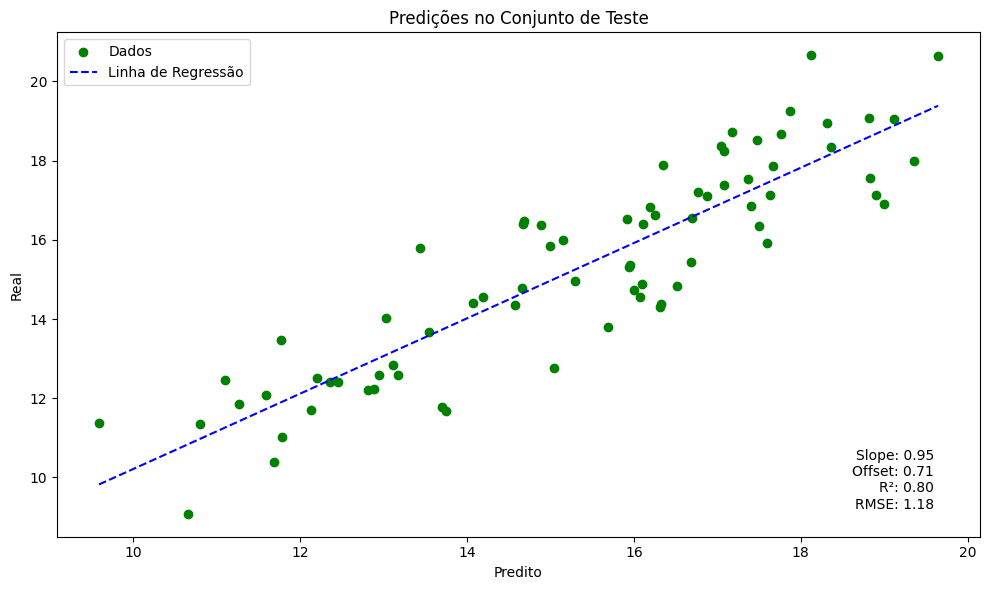

In [44]:
calibration_sg_ubs, validation_sg_ubs, Y_predict_sg_ubs, plot_infos = build_model(df_sg_cal, df_sg_cal['UBS (%)'], df_sg_val, df_sg_val['UBS (%)'], 'UBS', 'SG')

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'UBS (%)')

In [45]:
plot_infos_sg.to_excel('plot_infos_plsr_sg.xlsx', index=False)
plot_infos_sg

,Attribute,Y,R²,RMSE,Offset,Slope
0,SST,Referência,0.867817,0.895943,1.839389,0.867817
1,SST,Predição,0.792751,1.121860,2.471254,0.822261
2,SST,Validação,0.769322,1.241435,-1.269160,1.107408
3,PH,Referência,0.767023,0.146984,0.772320,0.767023
4,PH,Predição,0.398957,0.236084,1.390892,0.580786
5,PH,Validação,0.412284,0.201046,0.777409,0.755832
6,AT,Referência,0.744507,0.266457,0.286586,0.744507
7,AT,Predição,0.655266,0.309513,0.341363,0.695664
8,AT,Validação,0.347694,0.474677,0.175077,0.847216
9,FIRMEZA (N),Referência,0.708594,53.870526,147.553599,0.708594
